In [1]:
from tensorflow.python.client import device_lib
devices=device_lib.list_local_devices()
def sizeof_fmt(num,suffix='B'):
    for unit in ['','Ki','Mi','Gi', 'Ti', 'Pi','Ei','Zi']:
        if abs(num)<1024.0:
            return "%3.1f %s%s" %(num, unit, suffix)
        num/=1024.0
    return "%.1f%s%s" %(num, 'Yi', suffix)
for d in devices:
    t=d.device_type
    name=d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len (x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:GPU:0 ||  Quadro RTX 6000 || GPU || 21.3 GiB


In [2]:
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import pathlib
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow import losses, optimizers
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.metrics import top_k_categorical_accuracy
from scipy.ndimage import zoom
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
def CstmNet(input_shape=(128, 128, 64, 1)):

    X1_input = Input(input_shape)
    

    X1 = Conv3D(32, (9, 9, 9), strides=1, name='conv3', padding="same", kernel_initializer=glorot_uniform(seed=0))(X1_input)
    X1 = BatchNormalization(axis=-1)(X1)
    X1 = Activation('relu')(X1)
    X1 = MaxPooling3D(6, strides=6)(X1) 
    
    X1 = Conv3D(32, (6, 6, 6), strides=1, name='conv2', padding="same", kernel_initializer=glorot_uniform(seed=0))(X1)
    X1 = BatchNormalization(axis=-1)(X1)
    X1 = Activation('relu')(X1)
    X1 = MaxPooling3D(3, strides=3)(X1) 


    X1 = Conv3D(16, (3, 3, 3), strides=1, name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X1)
    X1 = BatchNormalization(axis=-1)(X1)
    X1 = Activation('relu')(X1)
    X1 = MaxPooling3D(3, strides=2)(X1)   
      
           
    X = Flatten()(X1)
    
############ Final Layer ######################
    
#     X = Dense(512, activation='relu', name='fc1', kernel_initializer=glorot_uniform(seed=0))(X)
#     X = Dropout(0.1)(X)
    X = Dense(256, activation='relu', name='fc2', kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dropout(0.2)(X)
    X = Dense(128, activation='relu', name='fc3', kernel_initializer=glorot_uniform(seed=0))(X)
    drop = Dropout(0.2)(X)
    output = Dense(1, activation='sigmoid', name='fc5',kernel_initializer=glorot_uniform(seed=0))(drop) 
    model = Model(inputs=[X1_input], outputs=output, name='CstmNet')
    
    return model

model = CstmNet(input_shape=(128, 128, 64, 1))
model.summary()

Model: "CstmNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3 (Conv3D)               (None, 128, 128, 64, 32)  23360     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64, 32)  128       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64, 32)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 21, 21, 10, 32)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 21, 21, 10, 32)    221216    
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 10, 32)    128 

In [4]:
import nibabel as nib
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image = nib.load(image_path)
            img = image.get_fdata()
            img = zoom(img, (0.533, 0.533, 0.413)) 
            img [img<0] = 0
            img_nor = img / np.max(img)
            img_nor = img_nor.astype(np.float32)
            
            img_data_array.append(img_nor)
            class_name.append(dir1)
    return img_data_array, class_name

## extract the image array and class name

img_train, class_train =create_dataset(r'C:/Dhruba Research Drive/Binary classification/enh/train')
img_test, class_test =create_dataset(r'C:/Dhruba Research Drive/Binary classification/enh/test')

####################################################################################################

target_dict={k: v for v, k in enumerate(np.unique(class_train))}
target_val=  [target_dict[class_train[i]] for i in range(len(class_train))]
print(target_dict)

target_dict_test={k: v for v, k in enumerate(np.unique(class_test))}
target_val_test=  [target_dict_test[class_test[i]] for i in range(len(class_test))]
print(target_dict_test)

#######################################################################################################
## CE only tumor Shape
## For Training Set ##

x1 = np.array(img_train, np.float32)
y_train = np.array(list(map(int,target_val)), np.float32)
X_train = np.expand_dims(x1, axis=4)

## For Test Set ###

x_test = np.array(img_test, np.float32)
y_test = np.array(list(map(int,target_val_test)), np.float32)
X_test = np.expand_dims(x_test, axis=4)


print("################ tumor only shapes #####################")

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

{'GBM': 0, 'Mets': 1}
{'GBM': 0, 'Mets': 1}
################ tumor only shapes #####################
(276, 128, 128, 64, 1)
(276,)
(31, 128, 128, 64, 1)
(31,)


In [3]:
import nibabel as nib
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image = nib.load(image_path)
            img = image.get_fdata()
            img = zoom(img, (0.533, 0.533, 0.413)) 
            img [img<0] = 0
            img_nor = img / np.max(img)
            img_nor = img_nor.astype(np.float32)
            
            img_data_array.append(img_nor)
            class_name.append(dir1)
    return img_data_array, class_name

# extract the image array and class name

img_test, class_test =create_dataset(r'C:\\Dhruba Research Drive\\External for binary\\Class_enhCE')

####################################################################################################

target_dict_test={k: v for v, k in enumerate(np.unique(class_test))}
target_val_test=  [target_dict_test[class_test[i]] for i in range(len(class_test))]
print(target_dict_test)


#######################################################################################################
### Enh_CE tumor Shape
## For Test Set ###
x_test=np.array(img_test, np.float32)
y_test=np.array(list(map(int,target_val_test)), np.float32)
X_test = np.expand_dims(x_test, axis=4)

print("################ Enh_CE tumor shapes #####################")
print(X_test.shape)
print(y_test.shape)

{'GBM': 0, 'Mets': 1}
################ Enh_CE tumor shapes #####################
(58, 128, 128, 64, 1)
(58,)


In [5]:
import scipy

def scaleit(image, factor, isseg=False):
    order = 0 if isseg == True else 3

    height, width, depth= image.shape
    zheight             = int(np.round(factor * height))
    zwidth              = int(np.round(factor * width))
    zdepth              = depth

    if factor < 1.0:
        newimg  = np.zeros_like(image)
        row     = (height - zheight) // 2
        col     = (width - zwidth) // 2
        layer   = (depth - zdepth) // 2
        newimg[row:row+zheight, col:col+zwidth, layer:layer+zdepth] = scipy.ndimage.interpolation.zoom(image, (float(factor), float(factor), 1.0), order=order, mode='nearest')[0:zheight, 0:zwidth, 0:zdepth]

        return newimg

    elif factor > 1.0:
        row     = (zheight - height) // 2
        col     = (zwidth - width) // 2
        layer   = (zdepth - depth) // 2

        newimg = scipy.ndimage.interpolation.zoom(image[row:row+zheight, col:col+zwidth, layer:layer+zdepth], (float(factor), float(factor), 1.0), order=order, mode='nearest')  
        
        extrah = (newimg.shape[0] - height) // 2
        extraw = (newimg.shape[1] - width) // 2
        extrad = (newimg.shape[2] - depth) // 2
        newimg = newimg[extrah:extrah+height, extraw:extraw+width, extrad:extrad+depth]

        return newimg

    else:
        return image
    
################################ CE  ######################################

img_aug_array=[]
class_aug_array = []
zoom = [0.9, 0.95, 1.0, 1.05, 1.1, 1.15]
for d in range (y_train.shape[0]):
    for e in range (6):
            volume = scaleit(X_train[d, :, :, :, 0], zoom[e], isseg=False)
            img_aug_array.append(volume)
            
            y_train_class = y_train[d]
            class_aug_array.append(y_train_class)
        
X_train_aug1_2 = np.array(img_aug_array, np.float32)
X_train_aug1_2 = np.expand_dims(X_train_aug1_2, axis=4)
print(X_train_aug1_2.shape)

y_train_aug1_2 = np.array(class_aug_array, np.float32)
print(y_train_aug1_2.shape)

(1656, 128, 128, 64, 1)
(1656,)


In [6]:
from scipy import ndimage
img_aug_array=[]
class_aug_array = []
angles = np.arange(-5, 6, 10)
for d in range (y_train.shape[0]):
    for e in range (2):
            volume = ndimage.rotate(img_train[d], angles[e], reshape=False)
            img_aug_array.append(volume)
            
            y_train_class = y_train[d]
            class_aug_array.append(y_train_class)

X_train_aug2 = np.array(img_aug_array, np.float32)
X_train_aug2 = np.expand_dims(X_train_aug2, axis=4)
print(X_train_aug2.shape)

y_train_aug2 = np.array(class_aug_array, np.float32)
print(y_train_aug2.shape)

(552, 128, 128, 64, 1)
(552,)


In [7]:
X_train_f1 = X_train_aug1_2[:, ::-1, :]
y_train_f1 = y_train_aug1_2

X_train_aug1 = np.concatenate((X_train_aug1_2, X_train_aug2, X_train_f1), axis=0)
print(X_train_aug1.shape)
y_train_aug1 = np.concatenate((y_train_aug1_2, y_train_aug2, y_train_f1), axis=0)
print(y_train_aug1.shape)

(3864, 128, 128, 64, 1)
(3864,)


In [ ]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


filepath = 'fold10_CstmNt_enhCE_2class.epoch{epoch:02d}-acc{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuray',
                             verbose=1, 
                             save_best_only=False,
                             mode='max')
callbacks = [checkpoint]

#for Adam optimizer
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=6e-4,
    decay_steps=10000,
    decay_rate=0.9)

optim = tf.keras.optimizers.Adam(learning_rate=1e-4)


model.compile(optimizer=optim,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results=model.fit(
          x=[X_train_aug1],
          y=[y_train_aug1],
          validation_data = ([X_test], y_test),
          epochs = 8,
          batch_size = 25,
          callbacks=callbacks)

In [4]:
classification_model = load_model('CstmNt_exter_enhCE_2class.epoch08-acc0.90.hdf5', compile = False)

In [5]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

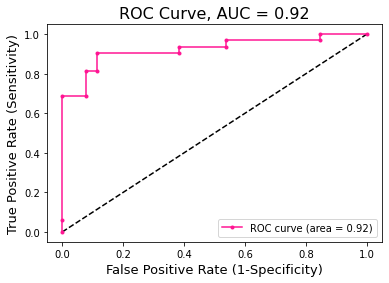

In [8]:
from matplotlib import pyplot
ns_probs = [0 for _ in range(len(y_test))]
y_pred = classification_model.predict(x=[X_test], batch_size = 25)
lr_probs = y_pred
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
#print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, color="black", linestyle='--')
pyplot.plot(lr_fpr, lr_tpr, color="deeppink", marker='.', label="ROC curve (area = {0:0.2f})".format(lr_auc))
# axis labels
pyplot.xlabel('False Positive Rate (1-Specificity)', fontsize=13)
pyplot.ylabel('True Positive Rate (Sensitivity)', fontsize=13)
plt.title('ROC Curve, AUC = %.2f'%lr_auc, fontsize=16)
# show the legend
pyplot.legend()
plt.legend(loc="lower right")
# save the fig
#plt.savefig('C:/Users/Dhruba/codes/bi_test AUC.tiff', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})
# show the plot
pyplot.show()

In [9]:
lr_fpr

array([0.        , 0.        , 0.        , 0.07692308, 0.07692308,
       0.11538462, 0.11538462, 0.38461538, 0.38461538, 0.53846154,
       0.53846154, 0.84615385, 0.84615385, 1.        ])

In [10]:
lr_tpr

array([0.     , 0.0625 , 0.6875 , 0.6875 , 0.8125 , 0.8125 , 0.90625,
       0.90625, 0.9375 , 0.9375 , 0.96875, 0.96875, 1.     , 1.     ])

In [11]:
lr_auc

0.9242788461538461